# A Pseudoproxy Experiment with "pseudoPAGES2k"

In this section, we illustrate the basic paleoclimate data assimilation (PDA) workflow with `cfr`, conducting a pseudoproxy experiment with "pseudoPAGES2k".

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import pandas as pd
import numpy as np

## Paleoclimate data assimilation (PDA) steps
### Create a reconstruction job object `cfr.ReconJob` and load the pseudoPAEGS2k database

(800.0, 2000.0)

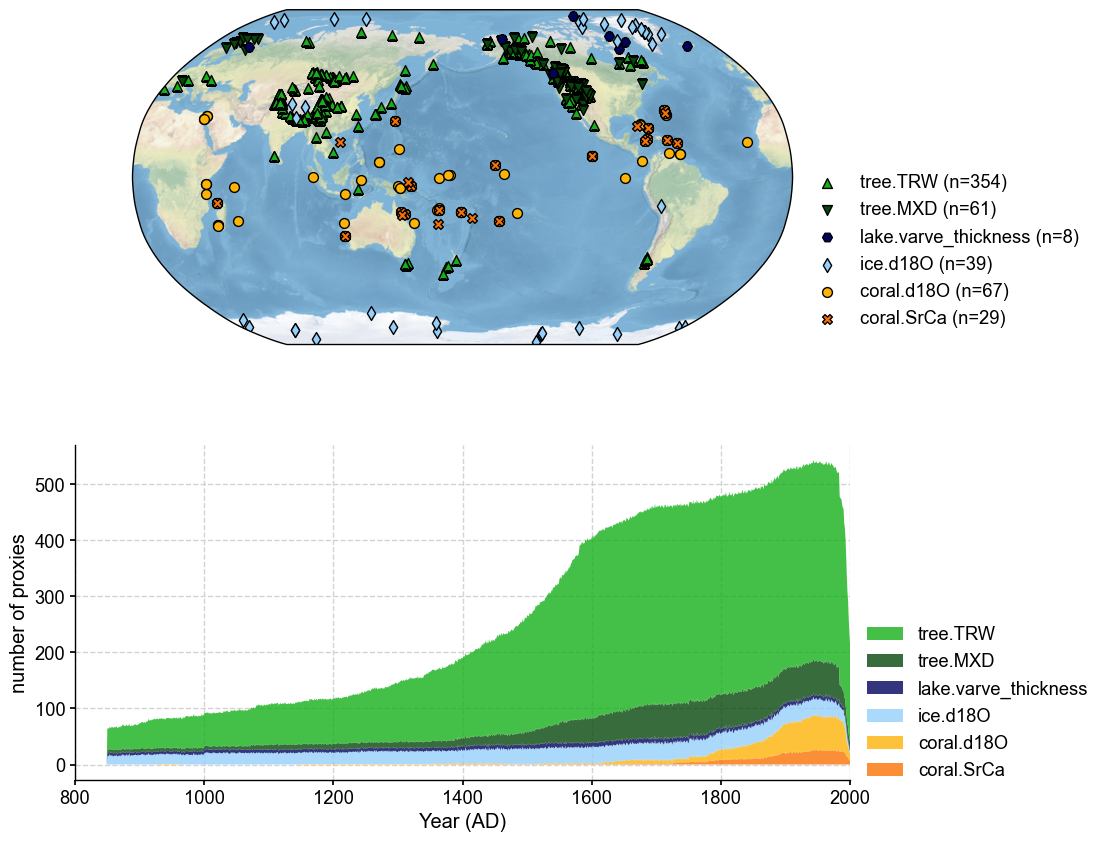

In [2]:
# create a reconstruction job object using the `cfr.ReconJob` class
job = cfr.ReconJob()

# load the pseudoPAGES2k database from a netCDF file
job.proxydb = cfr.ProxyDatabase().load_nc('./data/pp2k_nc/ppwn_SNR10_rta.nc')

# plot to have a check of the database
fig, ax = job.proxydb.plot(plot_count=True)
ax['count'].set_xlim(800, 2000)

### Load the model prior (iCESM simulated tas & pr fields) from two netCDF files

The `job.load_clim()` method loads gridded climate data from netCDF files and calculate anomalies based on given reference time interval (`anom_period`).
`tag='prior'` denotes that the loaded data will be used as the model prior.

In [3]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),  # calculate anomalies against the reference interval 1951-1980 CE
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = (1951, 1980)
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


### Load the instrumental observations from two netCDF files

As a perfect model prior pseudoproxy experiment (PPE), we use the iCESM simulated fields as instrumental observations.
Therefore, this step looks similar to the previous one, except for `tag='obs'`.

In [4]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
        'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc', 'pr': './data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas', 'pr'] loaded
>>> job.obs created


### Setup the proxy system models (PSMs) for different proxy types

We need to provide settings for the proxy system models before they can be properly calibrated, including:

- PSM to be used for each proxy type
- seasonality for each proxy type

In [5]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

### Calibrate the PSMs

Since the seasonality for TRW and MXD is undetermined, it can take a while to search for the optimal growing season for each site of TRW and MXD.

Note that PMSs cannot be calibrated at some sites due to the limited available data points over the instrumental period. These sites will be skipped for data assimilation.

In [6]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    verbose=True,)

>>> job.configs["ptype_psm_dict"] = {'tree.TRW': 'Bilinear', 'tree.MXD': 'Linear', 'coral.d18O': 'Linear', 'coral.SrCa': 'Linear', 'ice.d18O': 'Linear', 'lake.varve_thickness': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'tree.MXD': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 7, 8], [6, 7, 8, 9, 10, 11], [-12, 1, 2], [-9, -10, -11, -12, 1, 2], [-12, 1, 2, 3, 4, 5]], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
>>> job.configs["psm_calib_period"] = [1850, 2015]


Calibrating the PSMs:  13%|█▎        | 72/558 [07:13<47:01,  5.81s/it]  

The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 83/558 [08:10<30:59,  3.91s/it]  

The number of overlapped data points is 23 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 128/558 [12:21<34:41,  4.84s/it]

The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 133/558 [12:54<36:34,  5.16s/it]

The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  49%|████▊     | 272/558 [23:43<09:35,  2.01s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  57%|█████▋    | 319/558 [28:07<14:08,  3.55s/it]

The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...


Calibrating the PSMs:  59%|█████▉    | 332/558 [29:12<11:33,  3.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|██████    | 336/558 [29:21<06:10,  1.67s/it]

The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  85%|████████▌ | 476/558 [42:30<06:35,  4.82s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs: 100%|█████████▉| 557/558 [49:22<00:03,  3.02s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 558/558 [49:22<00:00,  5.31s/it]

>>> PSM for Asi_243 failed to be calibrated.
>>> PSM for Ocn_144 failed to be calibrated.
>>> PSM for Ant_022 failed to be calibrated.
>>> PSM for Ocn_145 failed to be calibrated.
>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Arc_045 failed to be calibrated.
>>> PSM for Asi_238 failed to be calibrated.
>>> PSM for Ant_016 failed to be calibrated.
>>> PSM for Ant_015 failed to be calibrated.
>>> PSM for Ant_014 failed to be calibrated.
>>> PSM for Arc_014 failed to be calibrated.
>>> 547 records tagged "calibrated" with ProxyRecord.psm created


### Run the PSMs

In [7]:
job.forward_psms(verbose=True)

Forwarding the PSMs: 100%|██████████| 547/547 [02:24<00:00,  3.79it/s]

>>> ProxyRecord.pseudo created for 547 records


### Annualize the model prior fields

This step will determine the temporal resolution of the reconstructed fields.

In [8]:
job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated


### Regrid the model prior fields

This step will determine the spatial resolution of the reconstructed fields.

In [9]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

Save the job object before running the DA procedure for a quick reload next time if needed.

In [10]:
job.save('./data/job-lmr-ppe-pages2k', verbose=True)

>>> job.configs["save_dirpath"] = ./data/job-lmr-ppe-pages2k
>>> prior_tas saved to: ./data/job-lmr-ppe-pages2k/prior_tas.nc
>>> prior_pr saved to: ./data/job-lmr-ppe-pages2k/prior_pr.nc
>>> obs_tas saved to: ./data/job-lmr-ppe-pages2k/obs_tas.nc
>>> obs_pr saved to: ./data/job-lmr-ppe-pages2k/obs_pr.nc
>>> job saved to: ./data/job-lmr-ppe-pages2k/job.pkl


Now let's reload the job object from the saved directory.

In [11]:
job = cfr.ReconJob()
job.load('./data/job-lmr-ppe-pages2k/', verbose=True)

>>> job is loaded
>>> job.prior["pr"].da is loaded
>>> job.prior["tas"].da is loaded
>>> job.obs["pr"].da is loaded
>>> job.obs["tas"].da is loaded


### Run the DA solver with Monte-Carlo iterations

In [12]:
job.run_da_mc(
    save_dirpath='./results/lmr-ppe-pages2k',
    recon_seeds=list(range(1, 3)),  # as an example here; normally set range(1, 21)
    recon_vars=['tas', 'pr'],  # to reconstruct both the tas and pr fields
    recon_period=[800, 2000],
    compress_params={'zlib': True, 'least_significant_digit': 5},  # pr requires more significant digits
    verbose=True,
)

>>> job.configs["recon_period"] = [800, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1, 2]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./results/lmr-ppe-pages2k
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 5}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 2


KF updating: 100%|██████████| 1201/1201 [32:56<00:00,  1.65s/it]


>>> Reconstructed fields saved to: ./results/lmr-ppe-pages2k/job_r01_recon.nc
>>> seed: 2 | max: 2


KF updating: 100%|██████████| 1201/1201 [43:22<00:00,  2.17s/it]


>>> Reconstructed fields saved to: ./results/lmr-ppe-pages2k/job_r02_recon.nc
>>> DONE! Total time used: 79.26 mins.


## Validation steps

### Create the reconstruction result object `cfr.ReconRes`

In [13]:
res = cfr.ReconRes('./results/lmr-ppe-pages2k', verbose=True)

>>> res.paths:
['./results/lmr-ppe-pages2k/job_r01_recon.nc', './results/lmr-ppe-pages2k/job_r02_recon.nc']


### Load the reconstructed variables

Here we validate `tas` and NINO3.4 index as an example.
We will load the `pr` fields anyway only to have a check.

In [14]:
res.load(['tas', 'pr', 'nino3.4'], verbose=True)

>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created
>>> ReconRes.recons["pr"] created
>>> ReconRes.da["pr"] created
>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created


### Validate the reconstructed NINO3.4

We calculate the annualized NINO3.4 from the "instrumental observations" as a reference for validation.

In [15]:
da = job.obs['tas'].annualize().da
da = cfr.utils.geo_mean(da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = [t for t in da.year]
ref_value = da.values
ref_name = 'truth'

We use a chain calling of several methods, including the validation step `.validate()` and the plotting step `.plot_qs()`.

(800.0, 2000.0)

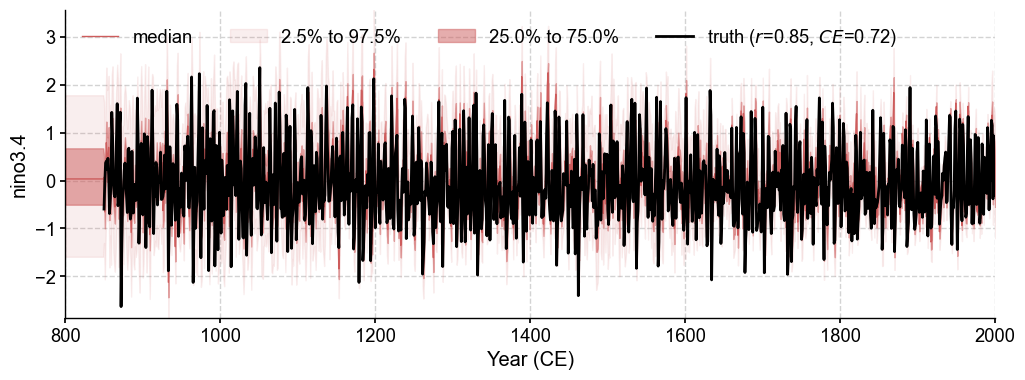

In [16]:
fig, ax = res.recons['nino3.4'].validate(ref_time, ref_value, ref_name).plot_qs()
ax.set_xlim(800, 2000)

### Validate the reconstructed fields (tas & pr)

In [17]:
# Preparations to add markers representing the sites on the map

lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pid, pobj in job.proxydb.filter(by='tag', keys=['calibrated']).records.items():
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 50

Calculate and visualize the coefficient of determination ($R^2$) between reconstructed and true tas fields.

/Users/fzhu/Apps/miniconda3/envs/cfr-env-py309/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


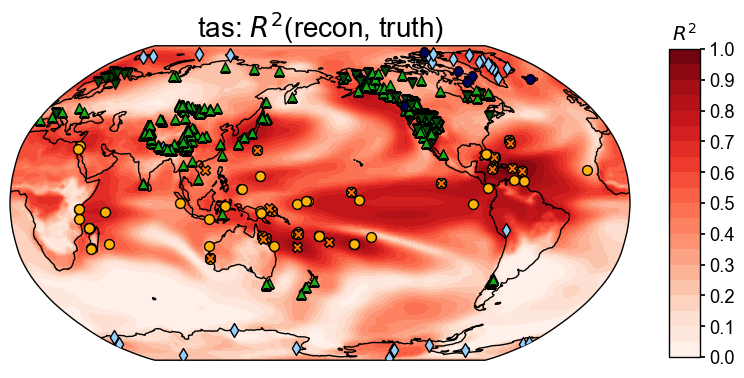

In [20]:
stat = 'R2'
valid_fd = res.recons['tas'].validate(
    job.obs['tas'].annualize(), stat=stat,
    valid_period=(1750, 1850),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'tas: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)

Calculate and visualize the coefficient of determination ($R^2$) between reconstructed and true pr fields.

/Users/fzhu/Apps/miniconda3/envs/cfr-env-py309/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1700: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


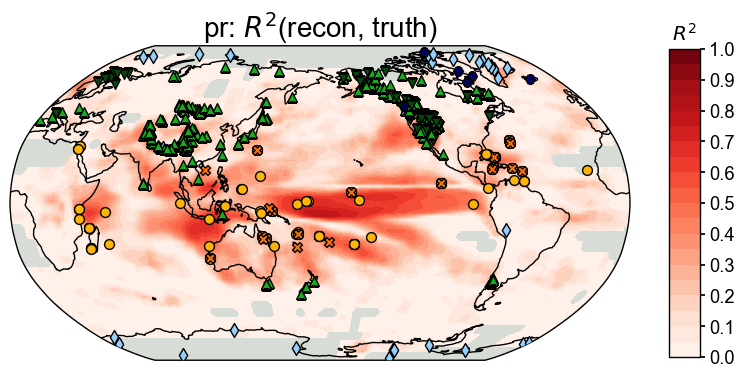

In [21]:
stat = 'R2'
valid_fd = res.recons['pr'].validate(
    job.obs['pr'].annualize(), stat=stat,
    valid_period=(1750, 1850),
    interp_direction='to-ref',
)
fig, ax = valid_fd.plot(
    title=fr'pr: $R^2$(recon, truth)',
    # projection='PlateCarree',
    # latlon_range=(-18, 18, 152, 248),
    add_cyclic_point=True,
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors, cbar_title_y=1,
    **valid_fd.plot_kwargs)